## **MEDfl Complete tutorial**

In this complete tutorial, we will demonstrate the utilization of the **MEDfl** package for establishing a federated learning environment to simulate model training using federated learning and transfer learning. The tutorial begins with the setup of the database, networks, and nodes using the netManager. This step ensures the creation of a federated dataset, setting the stage for the Learning Manager. In the Learning Manager, users have the flexibility to design and train custom models. Finally, the tutorial concludes with testing the model and comparing results across various configurations.

In [1]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']

Imports 

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


2024-03-08 10:45:47.561286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **1. Learning Manager**

In this tutorial, we will create an automated network using the eICU database. If you are interested in exploring additional options and getting more details about the Learning Manager sub-package, feel free to check the tutorial labeled `2_NetManager`.

#### 1.1 DB Preparation
DB Creation: 
Check the `1_DB-checkpoint` tutorial to learn more about this step

In [3]:
# If you didn't create the MEDfl database before you need to execute the script else you can skeep the next line and just empty the database 
!python3 ../../scripts/create_db.py

# clearn DB 
# empty_db()

#### 1.2 Network Creation


In [4]:
# Create a nestwork "Net_1"
Net_1 = Network(name="Auto_Net")
Net_1.create_network()

Net_1.name

/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/pandas/io/sql.py:1761: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  return insp.has_table(name, schema or self.meta.schema)


'Auto_Net'

In [5]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_train.csv


1

#### 1.3. Federeated Learning setup Creation (FlSetup creation)

In [6]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_1", description = "The first fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

,FLsetupId,name,description,creation_date,NetId,column_name
0,1,Flsetup_1,The first fl setup,2024-03-08 10:46:53,1,None


#### 1.4. Nodes Creation:


In [7]:
params_dict = {'column_name' : 'site_region','train_nodes' : ["Midwest","South"] , 'test_nodes' : ['West','Northeast'] }

eicu_nodes = autoFl.create_nodes_from_master_dataset(params_dict = params_dict )

[node.name  for node in eicu_nodes]  

ProgrammingError: (mysql.connector.errors.ProgrammingError) 1054 (42S22): Unknown column 'site_region' in 'field list'
[SQL: 
SELECT DISTINCT site_region FROM MasterDataset 
]
(Background on this error at: https://sqlalche.me/e/14/f405)

#### 1.5. Creating a Federated Dataset


In [8]:
# Create a Federated DataSet for the autoFL
fl_dataset = autoFl.create_federated_dataset(
    output="event_death", 
    fit_encode=["site_hospital", "site_region"], 
    to_drop=[ "event_death" , "id"], 
 )

In [9]:
fl_dataset.size

17

In [10]:
# Get the Federated DataSet of the auto FL 
data = autoFl.get_flDataSet() 
data 

,FedId,FLsetupId,FLpipeId,name
0,1,1,None,Flsetup_1_Feddataset


In [11]:
# List all created nodes on the db 
Node.list_allnodes()

,NodeId,NodeName,train,NetId
0,1,Midwest,1,1
1,2,South,1,1
2,3,West,0,1
3,4,Northeast,0,1


### 2. Learning manager

#### 2.1. Modal inialization
In this tutorial, we will use the dynamic model class to create a custom model. MEDfl enables users to create models from scratch or even use pre-trained models. For more details about the available options, please refer to Tutorial 4: Learning Manager.
Note that there is also a tutorial available for more detailed information about creating a dynamic model using MEDfl and the various parameters required for each model. 

In [12]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[-0.11073372, -0.03209594, -0.125385  ,  0.00995561,  0.18885155,
         -0.01376888, -0.05222048,  0.11559501, -0.03390973, -0.06356665,
          0.18317682,  0.01670368,  0.16447398,  0.13972408, -0.07454732,
          0.19271111,  0.15952957]], dtype=float32),
 array([0.2163465], dtype=float32)]

#### 2.2 Define the Aggregation Algorithms (**Aggregation Strategy**)

in this tuto we will use the FedAvg algorithm for the aggregation strategy 


In [13]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

####  2.3 Federated Learning Server


In [14]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = False ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

#### 2.4. FL Pipeline Creation


In [15]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the first fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [16]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-02-13 16:01:27,387 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
02/13/2024 16:01:27:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-13 16:01:29,521	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-13 16:01:31,855 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 39702983885.0, 'CPU': 24.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'node:__internal_head__': 1.0}
02/13/2024 16:01:31:INFO:Flower VCE: Ray initialized with resources: {'memory': 39702983885.0, 'CPU': 24.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-13 16:01:31,856 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
02/13/2024 16:01:31:INFO:Opt

Server-side evaluation loss 0.07913859933614731 / accuracy 0.75


DEBUG flwr 2024-02-13 16:01:39,457 | server.py:236 | fit_round 1 received 2 results and 0 failures
02/13/2024 16:01:39:DEBUG:fit_round 1 received 2 results and 0 failures
WARNING flwr 2024-02-13 16:01:39,462 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
02/13/2024 16:01:39:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-02-13 16:01:39,465 | server.py:125 | fit progress: (1, 0.07823415100574493, {'accuracy': 0.75}, 7.5899811499984935)
02/13/2024 16:01:39:INFO:fit progress: (1, 0.07823415100574493, {'accuracy': 0.75}, 7.5899811499984935)
DEBUG flwr 2024-02-13 16:01:39,466 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
02/13/2024 16:01:39:DEBUG:evaluate_round 1: strategy sampled 2 clients (out of 2)
(DefaultActor pid=32624) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training pe

Server-side evaluation loss 0.07823415100574493 / accuracy 0.75
(DefaultActor pid=32622) [Client 0] fit, config: {}
(DefaultActor pid=32622) epsilon of client 0 : eps = 0
Server-side evaluation loss 0.07783716917037964 / accuracy 0.75
Server-side evaluation loss 0.0777909979224205 / accuracy 0.75
(DefaultActor pid=32622) [Client 1] evaluate, config: {}
(DefaultActor pid=32622) [Client 0] evaluate, config: {}
Server-side evaluation loss 0.07798586785793304 / accuracy 0.75


DEBUG flwr 2024-02-13 16:01:39,682 | server.py:236 | fit_round 5 received 2 results and 0 failures
02/13/2024 16:01:39:DEBUG:fit_round 5 received 2 results and 0 failures
INFO flwr 2024-02-13 16:01:39,684 | server.py:125 | fit progress: (5, 0.07834416627883911, {'accuracy': 0.875}, 7.809318270999938)
02/13/2024 16:01:39:INFO:fit progress: (5, 0.07834416627883911, {'accuracy': 0.875}, 7.809318270999938)
DEBUG flwr 2024-02-13 16:01:39,686 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
02/13/2024 16:01:39:DEBUG:evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-13 16:01:39,706 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
02/13/2024 16:01:39:DEBUG:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 16:01:39,706 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
02/13/2024 16:01:39:DEBUG:fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-13 16:01:39,744 | serv

Server-side evaluation loss 0.07834416627883911 / accuracy 0.875
Server-side evaluation loss 0.07881074398756027 / accuracy 0.875
Server-side evaluation loss 0.07934608310461044 / accuracy 0.875
Server-side evaluation loss 0.07992179691791534 / accuracy 0.875


DEBUG flwr 2024-02-13 16:01:39,896 | server.py:187 | evaluate_round 8 received 2 results and 0 failures
02/13/2024 16:01:39:DEBUG:evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 16:01:39,896 | server.py:222 | fit_round 9: strategy sampled 2 clients (out of 2)
02/13/2024 16:01:39:DEBUG:fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-13 16:01:39,926 | server.py:236 | fit_round 9 received 2 results and 0 failures
02/13/2024 16:01:39:DEBUG:fit_round 9 received 2 results and 0 failures
INFO flwr 2024-02-13 16:01:39,928 | server.py:125 | fit progress: (9, 0.08051745593547821, {'accuracy': 0.875}, 8.052990127998783)
02/13/2024 16:01:39:INFO:fit progress: (9, 0.08051745593547821, {'accuracy': 0.875}, 8.052990127998783)
DEBUG flwr 2024-02-13 16:01:39,929 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
02/13/2024 16:01:39:DEBUG:evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-13 16:01:39,949 | serv

Server-side evaluation loss 0.08051745593547821 / accuracy 0.875
Server-side evaluation loss 0.08111836016178131 / accuracy 0.875


(DefaultActor pid=32624) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=32624)   warnings.warn(
(DefaultActor pid=32624) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=32624)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=32622) epsilon of client 0 : eps = 0
(DefaultActor pid=32622) [Client 0] evaluate, config: {}
(DefaultActor pid=32622) [Client 1] fit, config: {}
(DefaultActor pid=32622) epsilon of client 1 : eps = 0
(DefaultActor pid=32622) [Client 0] evaluate, config: {}


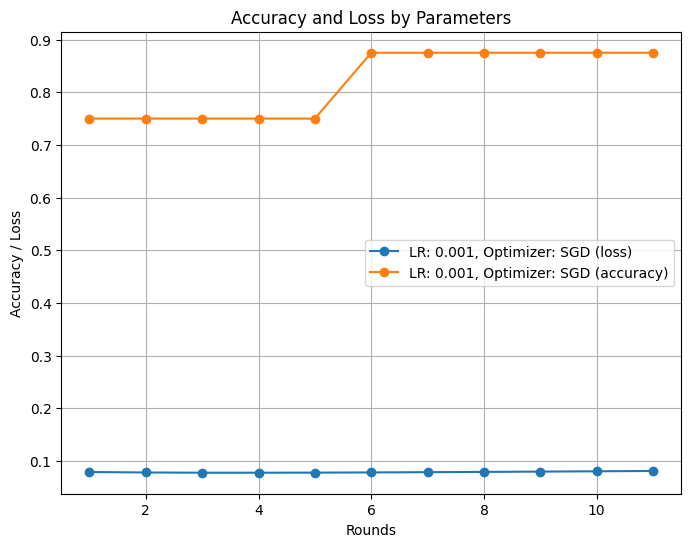

In [17]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [18]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'Midwest',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 4, 'FN': 1, 'TN': 13}, 'Accuracy': 0.722, 'Sensitivity/Recall': 0.0, 'Specificity': 0.765, 'PPV/Precision': 0.0, 'NPV': 0.929, 'F1-score': 0.0, 'False positive rate': 0.235, 'True positive rate': 0.0}"},
 {'node_name': 'South',
  'classification_report': "{'confusion matrix': {'TP': 1, 'FP': 6, 'FN': 5, 'TN': 20}, 'Accuracy': 0.656, 'Sensitivity/Recall': 0.167, 'Specificity': 0.769, 'PPV/Precision': 0.143, 'NPV': 0.8, 'F1-score': 0.154, 'False positive rate': 0.231, 'True positive rate': 0.167}"},
 {'node_name': 'West',
  'classification_report': "{'confusion matrix': {'TP': 3, 'FP': 22, 'FN': 18, 'TN': 50}, 'Accuracy': 0.57, 'Sensitivity/Recall': 0.143, 'Specificity': 0.694, 'PPV/Precision': 0.12, 'NPV': 0.735, 'F1-score': 0.13, 'False positive rate': 0.306, 'True positive rate': 0.143}"},
 {'node_name': 'Northeast',
  'classification_report': "{'confusion matrix': {'TP': 2, 'FP': 16, 'FN': 10, 